# 2D MPM for elastic body collision

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import utils
import visualizer

## Problem

This example considers two elastic circular body colliding with specified initial velocity. Two body has the same material property.

<img src="figs/sim_config.png" alt="Simulation configuration" style="width: 70%;"/>

## Material properties

In [2]:
E = 1000
nu = 0.3
rho = 2000

C = utils.elasticity_matrix(E, nu, "PLANE_STRAIN")
D = np.linalg.inv(C)

## Mesh

This step create background mesh. This example uses the following element (cell) and node numbering.
<img src="figs/mesh_example.png" alt="Mesh example" style="width: 70%;"/>


In [3]:
# length of domain
l = 1

# number of elements for each dim
n_ele_x = 20
n_ele_y = 20

# cell size
delta_x = l / n_ele_x
delta_y = l / n_ele_y

# number of grid nodes
n_node_x = n_ele_x + 1
n_node_y = n_ele_y + 1
n_nodes = n_node_x * n_node_y

# Generate mesh nodes
x_coords = np.linspace(0, l, n_node_x)
y_coords = np.linspace(0, l, n_node_y)
X, Y = np.meshgrid(x_coords, y_coords)
nodes = np.vstack([X.flatten(), Y.flatten()]).T

# Generate elements (connectivity)
elements = []
for j in range(n_node_y - 1):
    for i in range(n_node_x - 1):
        n1 = j * n_node_x + i
        n2 = n1 + 1
        n3 = n2 + n_node_x
        n4 = n1 + n_node_x
        elements.append([n1, n2, n3, n4])
elements = np.array(elements)
elements_coordinate_map = nodes[elements]
n_elements = elements.shape[0]

# Boundary nodes
bottom_nodes = np.where(nodes[:, 1] < 1e-8)[0]
upper_nodes = np.where(nodes[:, 1] > l - 1e-8)[0]
left_nodes = np.where(nodes[:, 0] < 1e-8)[0]
right_nodes = np.where(nodes[:, 0] > l - 1e-8)[0]

# Init node quantities
nodal_masses = np.zeros(n_nodes)  # nodal masses
nodal_momentums = np.zeros((n_nodes, 2))  # nodal momentums
nodal_iforces = np.zeros((n_nodes, 2))  # Internal forces
nodal_eforces = np.zeros((n_nodes, 2))  # External forces. Not used in this practice
# Init grid state variables
nodal_stresses = np.zeros((3, n_nodes))  # [sig_xx, sig_yy, sig_xy]
nodal_disp = np.zeros((2, n_nodes))  # [disp_x, disp_y]

## Particles

Two circular body is discretized with material points. The material points carry the information about velocity, position, stress, strain, mass, volume.

In [4]:

# Inputs for particles
n_particle_per_cell_per_dim = 2
vel_p1 = [0.15, 0.0]
vel_p2 = [-0.15, 0.0]

# Generate particles for two circles
spacing = delta_x / n_particle_per_cell_per_dim
particles1 = utils.generate_circle_particles(
    center=[0.2625, 0.4125], radius=0.15, spacing=spacing)
particles2 = utils.generate_circle_particles(
    center=[0.7375, 0.4125], radius=0.15, spacing=spacing)
pset_velocity1 = np.tile(vel_p1, (len(particles1), 1))
pset_velocity2 = np.tile(vel_p2, (len(particles2), 1))

# particle states
xp = np.vstack([particles1, particles2])
vp = np.vstack([pset_velocity1, pset_velocity2])
s = np.zeros((len(xp), 3))  # [sigma_xx, sigma_yy, sigma_xy]
eps = np.zeros((len(xp), 3))  # [epsilon_xx, epsilon_yy, gamma_xy]
Fp = np.tile([1.0, 0.0, 0.0, 1.0], (len(xp), 1))  # Deformation gradient

# Find elements to which particles belong
ele_ids_of_particles, p_ids_in_eles = utils.particle_element_mapping(
    xp, delta_x, delta_y, n_ele_x, n_elements)
active_elements = np.unique(ele_ids_of_particles)
active_nodes = np.unique(elements[active_elements, :])

# Compute initial particle volume
Vp = np.zeros(len(xp))
# Volume (area) of each background cell
for p_ids_in_ele in p_ids_in_eles:
    n_mp_in_element = len(p_ids_in_ele)
    if n_mp_in_element > 0:
        volume_per_mp = (delta_x * delta_y) / n_mp_in_element
        Vp[p_ids_in_ele] = volume_per_mp
Vp0 = Vp.copy()  # save initial volume
Mp = Vp * rho  # mass of particles

### See the mesh and particle configuration

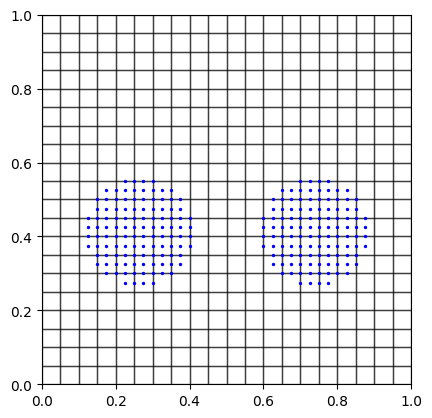

In [5]:
# Plot mesh, particles
meshes = [(nodes, elements)]
visualizer.plot_2d_meshes(meshes, xp)

## Analysis setting

In [6]:
dtime = 0.001
time = 3
t = 0
output_save_interval = 100
g = 0.5  # Gravity is reduced for taking a larger timestep.

## Run computation cycle
We are using explicit USL (update stress last) algoritm. The computation procedure is as follows. The details can be found in the original source ([Nguyen et al., 2023](https://doi.org/10.1007/978-3-031-24070-6)).

The entire computation cycle is as follows.

1. **Initialization**
   1. Set up the Cartesian grid, set time $t = 0$.
   2. Set up particle data: $x^0_p, v^0_p, \sigma^0_p, F^0_p, V^0_p, m_p, \rho_p^0, \rho_p^0$.

2. **while** $t < t_f$ **do**
   1. **Reset grid quantities**: $m^t_I = 0$, $(mv)^t_I = 0$, $f^{ext,t}_I = 0$, $f^{int,t}_I = 0$, $f^t_I = 0$.
   2. **Mapping from particles to nodes (P2G)**
      1. Compute nodal mass $m^t_I = \sum_p \phi_I(x^t_p)m_p$.
      2. Compute nodal momentum $(mv)^t_I = \sum_p \phi_I(x^t_p)(mv)^t_p$.
      3. Compute external force $f^{ext,t}_I = \sum_p \phi_I(x^t_p)m_pb(x_p)$.
      4. Compute internal force $f^{int,t}_I = - \sum_p V^0_p \sigma^t_p \nabla \phi_I(x^t_p)$.
      5. Compute nodal force $f^t_I = f^{ext,t}_I + f^{int,t}_I$.
   3. **Update the momenta** $(mv)^{t+\Delta t}_I = (mv)^t_I + f^t_I \Delta t$.
   4. **Fix Dirichlet nodes** $I$ e.g. $(mv)^t_I = 0$ and $(mv)^{t+\Delta t}_I = 0$.
   5. **Update particles (G2P)**
      1. Get nodal velocities $v^t_I = (mv)^t_I / m^t_I$ and $v^{t+\Delta t}_I = (mv)^{t+\Delta t}_I / m^t_I$.
      2. Update particle velocities
         $$
         v^{t+\Delta t}_p = \alpha \left(v^t_p + \sum_I \phi_I(x^t_p)\left[v^{t+\Delta t}_I - v^t_I \right] \right) + (1 - \alpha) \sum_I \phi_I(x^t_p)v^{t+\Delta t}_I
         $$
      3. Update particle positions 
         $$
         x^{t+\Delta t}_p = x^t_p + \Delta t \sum_I \phi_I(x^t_p)v^{t+\Delta t}_I
         $$
      4. Compute velocity gradient 
         $$
         L^{t+\Delta t}_p = \sum_I \nabla \phi_I(x^t_p)v^{t+\Delta t}_I
         $$
      5. Updated gradient deformation tensor 
         $$
         F^{t+\Delta t}_p = (I + L^{t+\Delta t}_p \Delta t) F^t_p
         $$
      6. Update volume 
         $$
         V^{t+\Delta t}_p = \text{det}(F^{t+\Delta t}_p) V^0_p
         $$
      7. Compute the rate of deformation matrix 
         $$
         D^{t+\Delta t}_p = 0.5(L^{t+\Delta t}_p + (L^{t+\Delta t}_p)^T)
         $$
      8. Compute the strain increment 
         $$
         \Delta \varepsilon_p = \Delta t D^{t+\Delta t}_p
         $$
      9. Update stresses:
         $$
         \sigma^{t+\Delta t}_p = \sigma^t_p + \Delta \sigma(\Delta \varepsilon_p) \quad \text{or} \quad \sigma^{t+\Delta t}_p = \sigma^t(F^{t+\Delta t}_p)
         $$
   6. **Advance time** $t = t + \Delta t$.
   7. **Error calculation**: if needed (e.g., for convergence tests).

3. **end while**

## Entire code

The following code implements the above algorithm.

In [7]:
times = []
kinetic_energy_evolution = []
strain_evergy_evolution = []

nsteps = int(time / dtime)

step = 0
pos = []
vel = []

print("Computation cycle started...")
while t < time:
    if step % output_save_interval == 0:
        print(f"Time: {t:.5f}/{time}")

    # Refresh the nodal values
    nodal_masses.fill(0)
    nodal_momentums.fill(0)
    nodal_iforces.fill(0)
    nodal_eforces.fill(0)
    nodal_stresses.fill(0)
    
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            # Evaluate shape function and its derivatives with respect to local coords (xi, eta) at (x, y).
            N, dNdxi = utils.lagrange_basis("Q4", pt)
            # Evaluate the Jacobian at current the current local coords (xi, eta).
            jacobian = node_coords.T @ dNdxi
            # Get the inverse of Jacobian
            inv_j = np.linalg.inv(jacobian)
            # Get the derivative of shape function with respect to global coords, i.e., (x, y)
            dNdx = dNdxi @ inv_j

            # Current stress of material points
            stress = s[p, :]
            
            # Iterate over the nodes of the current element & update nodal values by interpolating material point values
            for i, node_id in enumerate(node_ids):
                dNIdx = dNdx[i, 0]
                dNIdy = dNdx[i, 1]
                nodal_masses[node_id] += N[i] * Mp[p]
                nodal_momentums[node_id, :] += N[i] * Mp[p] * vp[p, :]
                nodal_iforces[node_id, 0] -= Vp[p] * (stress[0] * dNIdx + stress[2] * dNIdy)
                nodal_iforces[node_id, 1] -= Vp[p] * (stress[2] * dNIdx + stress[1] * dNIdy)
                nodal_eforces[node_id, 1] -= N[i] * Mp[p] * g

    nforce = nodal_iforces + nodal_eforces
    
    # Impose boundary condition
    nodal_momentums[left_nodes, 0] = 0
    nodal_momentums[right_nodes, 0] = 0
    nodal_momentums[bottom_nodes, 1] = 0
    nodal_momentums[upper_nodes, 1] = 0
    nforce[left_nodes, 0] = 0
    nforce[right_nodes, 0] = 0
    nforce[bottom_nodes, 1] = 0
    nforce[upper_nodes, 1] = 0
    
    # Update nomal momentum
    nodal_momentums += nforce * dtime    
    
    kinetic_energy = 0
    strain_energy = 0
    
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            N, dNdxi = utils.lagrange_basis("Q4", pt)  # shape function and its derivatives
            jacobian = node_coords.T @ dNdxi  # jacobian
            inv_j = np.linalg.inv(jacobian)
            dNdx = dNdxi @ inv_j
            Lp = np.zeros((2, 2))
            
            for i, node_id in enumerate(node_ids):
                vI = np.zeros(2)
                vp[p, :] += dtime * N[i] * nforce[node_id, :] / nodal_masses[node_id]
                xp[p, :] += dtime * N[i] * nodal_momentums[node_id, :] / nodal_masses[node_id]
                vI = nodal_momentums[node_id, :] / nodal_masses[node_id]  # nodal velocity
                Lp += vI.reshape(2, 1) @ dNdx[i, :].reshape(1, 2)  # particle velocity gradient

            F = Fp[p, :].reshape(2, 2) @ (np.eye(2) + Lp * dtime)  # deformation gradient
            Fp[p, :] = F.flatten()
            Vp[p] = np.linalg.det(F) * Vp0[p]  # update particle volume
            dEps = dtime * 0.5 * (Lp + Lp.T)  # strain increment
            dsigma = C @ np.array([dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]])  # stress increment
            s[p, :] += dsigma  # update stress
            eps[p, :] += [dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]]  # update strain

            kinetic_energy += 0.5 * (vp[p, 0] ** 2 + vp[p, 1] ** 2) * Mp[p]
            strain_energy += 0.5 * Vp[p] * s[p, :] @ eps[p, :]

            for i, node_id in enumerate(node_ids):
                nodal_stresses[:, node_id] += N[i] * s[p, :]

    pos.append(xp.copy())
    vel.append(vp.copy())
    
    # Update particle-element mapping (elements to which particles belong)
    ele_ids_of_particles, p_ids_in_eles = utils.particle_element_mapping(
        xp, delta_x, delta_y, n_ele_x, n_elements)
    active_elements = np.unique(ele_ids_of_particles)
    active_nodes = np.unique(elements[active_elements, :])

    times.append(t)
    kinetic_energy_evolution.append(kinetic_energy)
    strain_evergy_evolution.append(strain_energy)

    if step % output_save_interval == 0:
        result = {"positions": xp, "stress": s}
        save_dir = f"./results_vtk/"
        visualizer.save_vtk(step, result, save_dir)
        
    t += dtime
    step += 1
    

Computation cycle started...
Time: 0.00000/3
Time: 0.10000/3
Time: 0.20000/3
Time: 0.30000/3
Time: 0.40000/3
Time: 0.50000/3
Time: 0.60000/3
Time: 0.70000/3
Time: 0.80000/3
Time: 0.90000/3
Time: 1.00000/3
Time: 1.10000/3
Time: 1.20000/3
Time: 1.30000/3
Time: 1.40000/3
Time: 1.50000/3
Time: 1.60000/3
Time: 1.70000/3
Time: 1.80000/3
Time: 1.90000/3
Time: 2.00000/3
Time: 2.10000/3
Time: 2.20000/3
Time: 2.30000/3
Time: 2.40000/3
Time: 2.50000/3
Time: 2.60000/3
Time: 2.70000/3
Time: 2.80000/3
Time: 2.90000/3
Time: 3.00000/3


## Visualize the result

### Trajectory

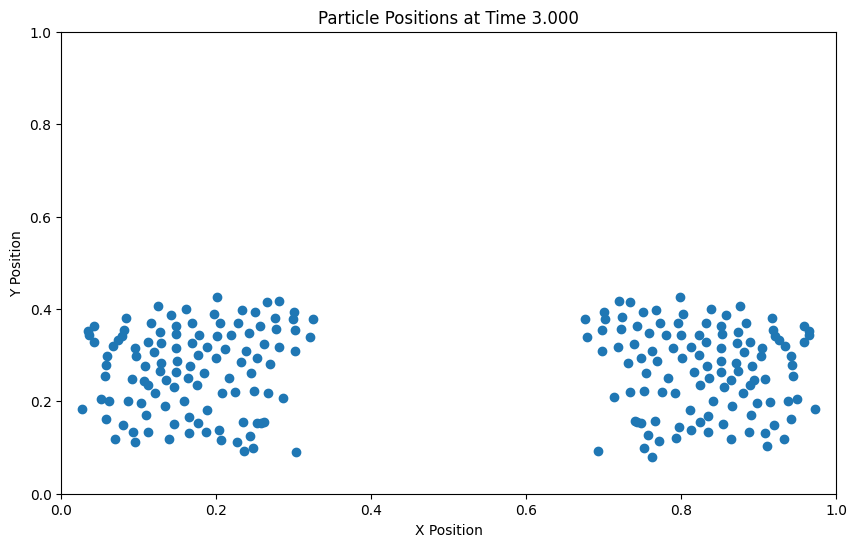

In [8]:
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Particle Positions Over Time')

# Initialize a scatter plot
scat = ax.scatter([], [])

# Update function for animation
def update(frame):
    scat.set_offsets(pos[frame])
    ax.set_title(f'Particle Positions at Time {times[frame]:.3f}')
    return scat,

# Create the animation
ani = FuncAnimation(
    fig, update, frames=range(0, len(times), output_save_interval), interval=100, blit=True)

# Display the animation in the notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

### Energy evolution

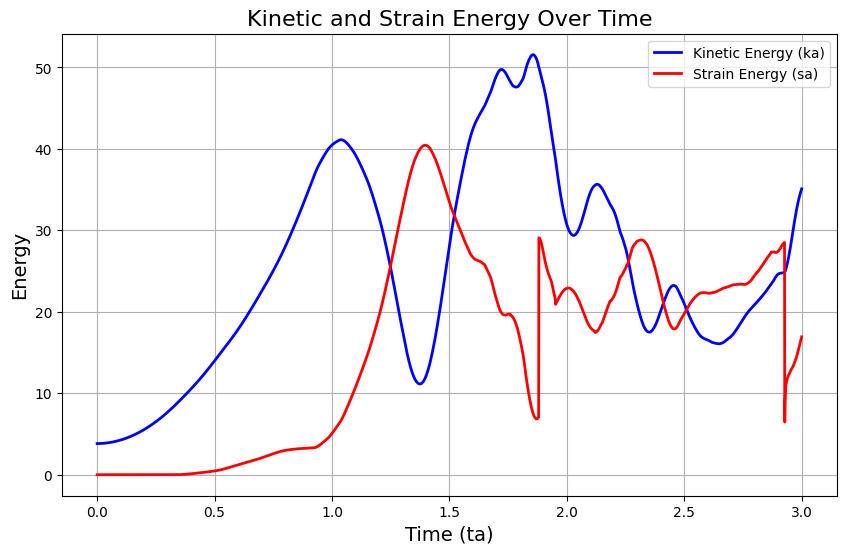

In [9]:
# Plot kinetic and strain energy
plt.figure(figsize=(10, 6))
plt.plot(times, kinetic_energy_evolution, label='Kinetic Energy (ka)', color='b', linewidth=2)
plt.plot(times, strain_evergy_evolution, label='Strain Energy (sa)', color='r', linewidth=2)
plt.xlabel('Time (ta)', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Kinetic and Strain Energy Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()